# Labeling Correction Algorithm求解SPPRC

In [6]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import os
import copy

## 1 数据打印函数

In [7]:
# 创建数据存储对象
class Data():
    customerNum = 0
    nodeNum     = 0
    vehicleNum  = 0
    capacity    = 0
    cor_X       = []
    cor_Y       = []
    demand      = []
    readyTime   = []
    dueTime     = []
    serviceTime = []
    disMatrix   = []

# 数据读取函数
def readData(data, path, customerNum):
    data.customerNum = customerNum
    data.nodeNum = customerNum + 2   # 比customerNum多两个点

    count = 0
    f = open(path, 'r')
    lines = f.readlines()
    for line in lines:
        count += 1
        if(count == 5):
            line = line[:-1].strip()
            stri = re.split(r' +', line)
            data.vehicleNum = int(stri[0])
            data.capacity = int(stri[1])
        elif(count >= 10 and count <= 10 + customerNum):
            line = line[:-1].strip()
            stri = re.split(r' +', line)
            data.cor_X.append(float(stri[1]))
            data.cor_Y.append(float(stri[2]))
            data.demand.append(float(stri[3]))
            data.readyTime.append(float(stri[4]))
            data.dueTime.append(float(stri[5]))
            data.serviceTime.append(float(stri[6]))
    
    # 将初始点作为终点
    data.cor_X.append(data.cor_X[0])
    data.cor_Y.append(data.cor_Y[0])
    data.demand.append(data.demand[0])
    data.readyTime.append(data.readyTime[0])
    data.dueTime.append(data.dueTime[0])
    data.serviceTime.append(data.serviceTime[0])

    data.disMatrix = [[[0] for i in range(data.nodeNum)] for j in range(data.nodeNum)]
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            temp =  (data.cor_X[i] - data.cor_X[j])**2 + ( data.cor_Y[i]-data.cor_Y[j])**2
            data.disMatrix[i][j] = math.sqrt(temp)
            temp = 0

    return data

# 数据打印函数
def printData(data, customerNum):
    print('\n---------基本信息---------')
    print('Vehicle number is {:>6d}' .format(data.vehicleNum))
    print('Vehicle capacity is {:>4d}' .format(data.capacity))
    for i in range(customerNum):
        print('{:>4.1f}, {:5.1f}, {:>6.1f}, {:>4.1f}'.format(data.demand[i], data.readyTime[i], data.dueTime[i], data.serviceTime[i]))
    
    print('\n---------距离矩阵---------')
    for i in range(data.nodeNum):
        for j in range(data.nodeNum):
            print('{:>3.1f}'.format(data.disMatrix[i][j]), end = "")
        print()

# 读取数据
data = Data()
path = 'c101.txt'
customerNum = 100
data = readData(data, path, customerNum)

# printData(data, customerNum)

## 2 网络图构建

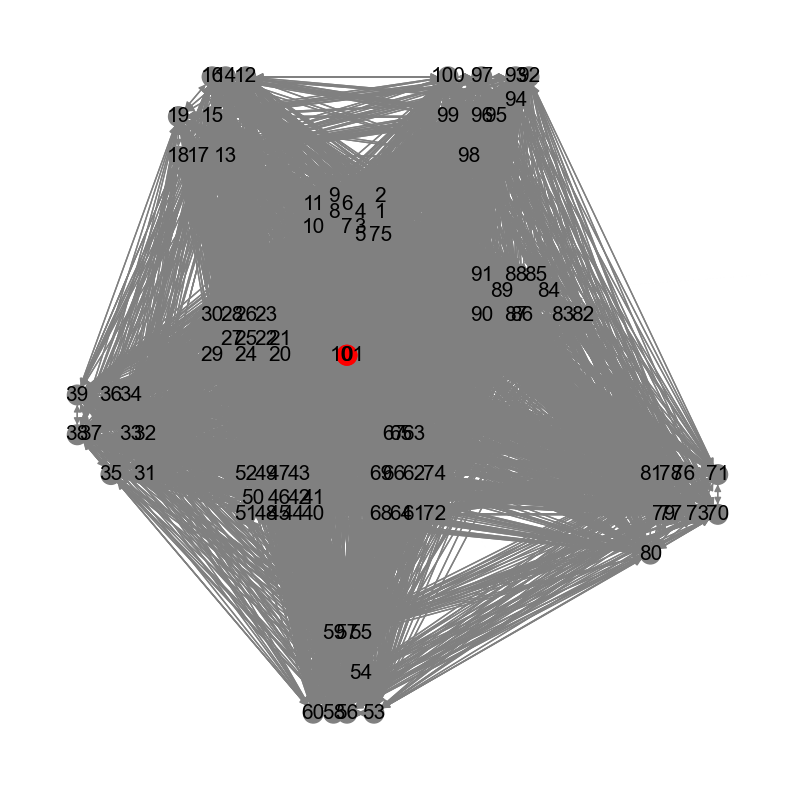

In [8]:
from matplotlib import pyplot as plt


Graph = nx.DiGraph()
cnt = 0
pos_pair  = {}      # node id 与 node 坐标的键值对
nodes_col = {}      # 节点颜色

# 添加node
for i in range(data.nodeNum):
    x_cor = data.cor_X[i]
    y_cor = data.cor_Y[i]
    name = str(i)
    nodes_col[name] = 'gray'
    node_type = 'customer'
    if(i==0):
        node_type = 'depot'
    Graph.add_node(name,
                ID = i,
                node_type = node_type,
                time_window = (data.readyTime[i], data.dueTime[i]),
                arrival_time = 10000,  # 时间标签
                demand = data.demand,
                service_time = data.serviceTime,
                x_coor = x_cor,
                y_coor = y_cor,
                min_dis = 0,           # 距离标签
                previous_node = None   # 保存前序节点标签
                )

    pos_pair[name] = (x_cor, y_cor)

# 添加edge
for i in range(data.nodeNum):
    for j in range(data.nodeNum):
        if(i==j or (i == 0 and j == data.nodeNum - 1) or  (j == 0 and i == data.nodeNum - 1)):
            pass
        else:
            Graph.add_edge(str(i), str(j),
                        travelTime = data.disMatrix[i][j],
                        length = data.disMatrix[i][j])

# 绘图
nodes_col['0'] = 'red'
nodes_col[str(data.nodeNum - 1)] = 'red'

fig, ax = plt.subplots(figsize = (10,10))
nx.draw(Graph
        , pos=pos_pair
        , ax = ax
        , with_labels = True
        , node_size = 200
        , node_color = nodes_col.values()
        , font_size = 15
        , font_family = 'arial'
        , edge_color = 'grey'
)

## 3 标签算法与优超准则
- Labeling correction algorithm
- Dominace rule：优超准则（相同尾结点、资源向量消耗的比较、可拓展集合的大小）

In [15]:
from networkx.algorithms import dominance


class Label:
    path = []
    time = 0
    dis = 0

def labelling_SPPRC(Graph, org, des):

    # 初始队列
    Queue = []

    # 创建初始标签
    label = Label()
    label.path = [org]
    label.dis = 0
    label.time = 0
    Queue.append(label)

    Paths = {}
    cnt = 0
    while(len(Queue)>0):
        cnt += 1
        current_path = Queue[0]
        Queue.remove(current_path)

        # 对模型进行拓展
        last_node = current_path.path[-1]
        for child in Graph.successors(last_node):        # Graph.successors 会返回与节点相连的所有后继节点
            extended_path = copy.deepcopy(current_path)
            extended_arc = (last_node, child)
            
            # 判断拓展路径是否可行，否在既有路径中，是否满足时间窗
            arrival_time = current_path.time + Graph.edges[extended_arc]['travelTime']
            time_window = Graph.nodes[child]['time_window']
            if((child not in extended_path.path) and arrival_time >= time_window[0] and arrival_time <= time_window[1]):
                extended_path.path.append(child)
                extended_path.dis += Graph.edges[extended_arc]['length']
                extended_path.time += Graph.edges[extended_arc]['travelTime']
                Queue.append(extended_path)
                print('extended_path: ', extended_path.path)
            else:
                pass

        Paths[cnt] = current_path

        # dominance step
        Queue, Paths = dominance(Queue, Paths)

    # 过滤Path，只保留从org到des的路径，删去其他所有路径
    Paths_copy = copy.deepcopy(Paths)
    for key in Paths_copy.keys():
        if(Paths[key].path[-1] != des):
            Paths.pop(key)
    
    # 选择最优解
    opt_path = {}
    min_distance = 10000000
    for key in Paths.keys():
        if(Paths[key].dis < min_distance):
            min_distance = Paths[key].dis
            opt_path['1'] = Paths[key]
        
    return Graph, Queue, Paths, Paths_copy, opt_path

# 4 优超准则函数

In [17]:
def dominance(Queue, Paths):
    Queue_copy = copy.deepcopy(Queue)
    Paths_copy = copy.deepcopy(Paths)

    # Queue
    for label in Queue_copy:
        for another_label in Queue:
            if(label.path[-1] == another_label.path[-1] and label.time < another_label.time and label.dis < another_label.dis ):
                Queue.remove(another_label)
                print('delete path(Q)', another_label.path)

    # Path
    for key_1 in Paths_copy.keys():
        for key_2 in Paths_copy.keys():
            if(Paths_copy[key_1] == Paths_copy[key_2] and Paths_copy[key_1].time <  Paths_copy[key_2].time and Paths_copy[key_1].dis <  Paths_copy[key_2].dis):
                Paths.remove(key_2)
                print('delete path(P)', key_2.path)
    
    return Queue, Paths

# 算例测试

In [18]:
data = Data()
path = 'c101.txt'
customerNum = 100
data = readData(data, path, customerNum)

org = '0'
des = str(data.nodeNum - 1)
Graph, Queue, Paths, Paths_copy, opt_path = labelling_SPPRC(Graph, org, des)

for key in Paths.keys():
    print(Paths[key].path)

print('optimal path: ', opt_path['1'].path)
print('optimal path distance: ', opt_path['1'].dis)
print('optimal path time: ', opt_path['1'].time)

extended_path:  ['0', '5']
extended_path:  ['0', '13']
extended_path:  ['0', '20']
extended_path:  ['0', '32']
extended_path:  ['0', '43']
extended_path:  ['0', '57']
extended_path:  ['0', '67']
extended_path:  ['0', '81']
extended_path:  ['0', '90']
extended_path:  ['0', '98']
extended_path:  ['0', '5', '13']
extended_path:  ['0', '5', '20']
extended_path:  ['0', '5', '32']
extended_path:  ['0', '5', '43']
extended_path:  ['0', '5', '57']
extended_path:  ['0', '5', '67']
extended_path:  ['0', '5', '81']
extended_path:  ['0', '5', '90']
extended_path:  ['0', '5', '98']
extended_path:  ['0', '5', '101']
delete path(Q) ['0', '5', '13']
delete path(Q) ['0', '5', '20']
delete path(Q) ['0', '5', '32']
delete path(Q) ['0', '5', '43']
delete path(Q) ['0', '5', '57']
delete path(Q) ['0', '5', '67']
delete path(Q) ['0', '5', '81']
delete path(Q) ['0', '5', '90']
delete path(Q) ['0', '5', '98']
extended_path:  ['0', '13', '5']
extended_path:  ['0', '13', '20']
extended_path:  ['0', '13', '32']
e